# Assignment 2

## Part 0: Loading the data 

### 0.1 Load libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random as ran
import collections
import math
import functools
import operator
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, FactorRange, Legend, HoverTool, VBar
from bokeh.plotting import figure, output_file, show
from bokeh import palettes

  
from bokeh.sampledata.periodic_table import elements
from bokeh.transform import dodge, factor_cmap 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
 
from imblearn.under_sampling import RandomUnderSampler

from dtreeviz.trees import dtreeviz 
 
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight') # For better style
plt.rcParams["font.family"] = "DejaVu Sans"
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
 

### 0.2 Load crime-data

In [4]:
column_list = ["age", "sex", "race", "juv_fel_count", "juv_misd_count", "juv_other_count",
               "priors_count", "two_year_recid", "days_b_screening_arrest"]
# Read data from file recidivism and load into pandas

df = pd.read_csv("https://raw.githubusercontent.com/suneman/socialdata2022/main/files/recidivism_dataset_sub.csv", usecols=column_list)

# Part 1: Predicting criminal recidivism

## Exercise 1: Build a Decision Tree or a Random Forest.

* **1.1: Preprocess the data by only keeping records that have between -30 and 30 days between the arrest and screening, then drop the days_b_screening_arrest column for the upcoming analysis.**

In [5]:
#preprocess the data 
df_preprocessed=df[ ((df.days_b_screening_arrest > -30) &( df.days_b_screening_arrest < 30))]
#drop column 
df_preprocessed = df_preprocessed.drop(columns=['days_b_screening_arrest' ])


* **1.2: Some features we are working with are categorical, so we need to deal with them by using encoders. There are many different types, but we will focus on the OneHotEncoder and the LabelEncoder:Which encoder did you choose? Describe what it does and why you chose it.**

We will be using OneHotEncoder to replace the existing text data with the new encoded data. OneHotEncoder creates additional features based on the number of unique values in the categorical feature while LabelEncoder&nbsp;encode text labels with a value between 0 and n-1 where n is the number of distinct class labels. The encoding from 0 to n-1 in LabelEncoder creates an unnecessary ordering for the model to learn as there are different numbers in the same column. This introduces an unnecessary ranking for the model which we want to avoid. Hence we are using OneHotEncoder despite its computational costs.

In [4]:
#Making age as categories and then one hot encoding age, sex and race group.

# Age group 
bins= [18,30,40,50,60,70,80,90,100]
labels = ['<18','18-30','30-40','40-50','50-60','60-70','80-90','>90']
df_preprocessed['AgeGroup'] = pd.cut(df_preprocessed['age'], bins=bins, labels=labels, right=False)
df_age=df_preprocessed.groupby(['AgeGroup']).count()[['age']].reset_index()

#Encoding
df_dummies=pd.get_dummies(df_preprocessed, columns=['sex','race','AgeGroup'])


In [5]:
#Extracting features to be used for prediction and Labels to predict.


# Labels are the category that we want to predict
labels = df_dummies["two_year_recid"].to_numpy()

# Drop the Category column from the dataframe and convert it into numpy array for prediction
features = df_dummies.drop("two_year_recid", axis = 1).to_numpy()

# Saving feature names for future use
feature_list = df_dummies.drop("two_year_recid", axis = 1).columns

* **1.3: Split the data in Train/Test sets by using a 70/30 split and random_state=42.**

In [6]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = \
train_test_split(features, labels, test_size = 0.3, random_state = 42, stratify = labels)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (4311, 21)
Training Labels Shape: (4311,)
Testing Features Shape: (1848, 21)
Testing Labels Shape: (1848,)


* **1.4: Fit a model to your Train set. Choose between a DecisionTreeClassifier or a RandomForestClassifier.Describe how the model you chose works and why you chose it.**

In [7]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 600, criterion = 'entropy', random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

* **1.4.1: Describe how the model you chose works and why you chose it.**

We chose Random Forest Classifier. Random Forest is a tree-based machine learning algorithm that leverages the power of multiple decision trees for making decisions. Each node in the decision tree works on a random subset of features to calculate the output. The random forest then combines the output of individual decision trees to generate the final output. The Random Forest Algorithm combines the output of multiple (randomly created) Decision Trees to generate the final output.

The reason we chose it because random forest leverages the power of multiple decision trees and helps in preventing overfitting of data that can be seen in decision trees. Random forest chooses features randomly during the training process.  Therefore, it does not depend highly on any specific set of features and can generalize over the data in a better way. This randomized feature selection makes random forest much more accurate than a decision tree. This randomized approach makes random forest difficult to interpret. Since interpretability is not a major concern for us, we have chosen the Random Forest Classifier.

We also evaluated their performance empirically on the based on the F-1 score and found that random forest classifier works better in our case too.

In [8]:
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
dt.fit(train_features, train_labels)
dt_pred_train = dt.predict(train_features)

print('Training Set Evaluation F1-Score=>',f1_score(train_labels,dt_pred_train))

# Evaluating on Test set
dt_pred_test = dt.predict(test_features)
print('Testing Set Evaluation F1-Score=>',f1_score(test_labels,dt_pred_test))


Training Set Evaluation F1-Score=> 0.7761024182076814
Testing Set Evaluation F1-Score=> 0.5515873015873017


In [9]:
#Using the random forest trained before in 1.3 forr evaluation

# Evaluating on Training set
rf_pred_train = rf.predict(train_features)
print('Training Set Evaluation F1-Score=>',f1_score(train_labels,rf_pred_train))

# Evaluating on Test set
rf_pred_test = rf.predict(test_features)
print('Testing Set Evaluation F1-Score=>',f1_score(test_labels,rf_pred_test))

Training Set Evaluation F1-Score=> 0.7884977156678312
Testing Set Evaluation F1-Score=> 0.5901434809731753


Here you can see that the random forest classifier performs better than the decision tree classifier for both the training and test set when evaluated based on the F-1 score which provides an estimate of both precision and recall.

* **1.5: Evaluate the performance of model on the test set, i.e compute Accuracy, Precision, and Recall.**

In [10]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy =  np.sum(predictions == test_labels) / len(test_labels)
    precision = precision_score(predictions, test_labels)
    recall = recall_score(predictions, test_labels)
    f1score = 2*(precision*recall)/(precision+recall)

    print('Model Performance\n')
    print('Accuracy = {:0.4f}'.format(accuracy))
    print('Precison = {:0.4f}'.format(precision))
    print('Recall   = {:0.4f}'.format(recall))
    print('F1 Score = {:0.4f}'.format(f1score))

In [11]:
evaluate(rf,test_features,test_labels)


Model Performance

Accuracy = 0.6445
Precison = 0.5624
Recall   = 0.6207
F1 Score = 0.5901


* **1.5.1: What are your thoughts on these metrics? Is accuracy a good measure?**

Accuracy is not the best measure in our case since the value of false positive and false negative is not the same. A false negative has much higher implications where you might loose the opportunity to stop a heinous crime if the model is wrong compared to a false positive which still not great but only ends up wasting time of law enforcement and the crimina being in jail for longer despite having low propensity to commit a crime again. 

Precision measures the number of correctly predicted positive observations among all predicted positive observations. This is a better measure than accuracy in our case, as this would help us not waste of lot of time for the law enforcement officers in pursuing wrongly identiied suspects. 

While Recall is the ratio of correctly predicted positive observations to the all observations in actual positive class. This makes recall a better metric than accuracy in our case because this way we can measure the performance of the model on the number of suspects missed by the model.\n

So we think that the F1 score which is the weighted average of Precision and Recall is the best metric to measure the model's performance for our use case.

* **1.6: Are your results tied to the specific hyperparameter set you used? Perform a RandomizedSearchCV and recompute the performance metric above with the hyperparameters found. What do you observe?**

Hyperparameters currently in use.

In [12]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 600,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


RandomizedSearchCV

In [13]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [166]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [167]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [15]:
base_model = RandomForestClassifier(n_estimators = 400, random_state = 42,min_samples_split=2, min_samples_leaf=4,max_features='sqrt',max_depth=10, bootstrap=True)
base_model.fit(train_features, train_labels)
evaluate(base_model, test_features, test_labels)

Model Performance

Accuracy = 0.6883
Precison = 0.5826
Recall   = 0.6853
F1 Score = 0.6298


* **1.7: Visualize the tree. There are different options to do so. You can have a look at Week 6 for hints on how to do it. What do you observe?**

In [16]:
n_nodes = base_model.estimators_[0]
n_nodes

DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                       random_state=1608637542)

In [17]:
from dtreeviz.trees import dtreeviz 
plt.rcParams["font.family"] = "DejaVu Sans"

cn=['No','Yes']

viz = dtreeviz(base_model.estimators_[0], train_features, train_labels,
                target_name="Two year Recividism",
                feature_names = feature_list ,
                class_names=cn,
                )

viz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


# Part 2: Fairness and bias in Machine Learning

### Exercise 2.1: A few questions about bias.

* **2.1.1: What are the most common types of data bias?**

The most common types of data biases are as follows-:

1. Response or Activity Bias. 
2. Selection bias due to feedback loops.
3. Bias due to system drift.
4. Omitted variable bias
5. Societal bias

* **2.1.2: What are the potential bias sources/types in our case-study (i.e. recidivism)?**

By observing the decision tree that we have visualised we can see some potential bias in the dataset. Some of the biases are as follows:

1. African/American defendendants are labeled a higher risk to re-offend. Whether the defendant is African/American is the moost important question when it comes to classifying male defendants. It can be shown that African American males suffer from this bias where they are more likely to classified as criminals/reoffenders. But you can see in the visiaulization above if you look at the stacked bar chart fro African/american Males, that whether they reoffend or not is fairly equally balanced when it comes to reality. This bias stems from how the society percieves these individuals along with systemic drift over a lot of years that has created these feedback loops where these are more disadvantaged economically leading them to use unlawful means for survival. Similarly there should be potential societal biases when it comes to other races too like caucausian. 

2. Another potential bias is around gender. Whether the defendant is male or not is the most important question in the decision tree, despite there almost being a 50-50 chance wahether a male reoffends are not. This could be stemming from societial biases that men are generally more violent and criminal or they dont change theit toxic behaviors and are more likely to keep repeating their wrong habits.

3. The bias due to the result of years of structural discrimination in recording  long before the present data is recorded

4. Another reasoning for a bias could be from how the data is collected and what sample population is being used to collect the data and whether they are representative of a larger population or not where you intend to use the model in the end.

### Exercise 2.2: Equal Odds. We are going to use y_prob to debias the ML model for African-Americans and Caucasians.

* **2.2.1: Define the thresholds**

In [18]:
ths = np.linspace(1e-5,1-1e-5, 10) 

In [19]:
#function creates an array with the y_hats for all threshold values in the range
# outputs a 2 dimension array where each row has yhat values for the corresponging threshold values
# if threshold is of size n and y_prob of size m, then the output is of size n*m

def y_hat_calculate(thresholds, y_prob):

    result_array = np.zeros((len(y_prob),len(thresholds)))

    for counter, threshold in enumerate(thresholds):
        
        y_pred_threshold = np.zeros(len(y_prob))

        for i, _ in enumerate(y_prob):
         
            if y_prob[i] > threshold:
                y_pred_threshold[i] = 1
            else:
                y_pred_threshold[i] = 0
    
        result_array[:, counter] = np.copy(y_pred_threshold)

    return(result_array)

**The method used to find the thresholds**

We are going to be using the visual method  for identifying thresholds. In this method, you try to find the thresholds visually that lead to the smaller distance (but suitable FPR and TPR). The reason we prefer doing this visually is because the ROC plot could give us a better overview of the distribution of tpr and fpr based on thresholds and gives us the opportunity to selecte optimal values thresholds which are not only close to each other but have a suitable  FPR and TPR values as well.

In [20]:
df_caucasian = df_dummies[df_dummies.race_Caucasian == 1]
df_african= df_dummies.loc[df_dummies['race_African-American'] == 1]

# Labels are the category that we want to predict
y_caucasian = df_caucasian["two_year_recid"].to_numpy()
y_african = df_african["two_year_recid"].to_numpy()

# Drop the Category column from the dataframe and convert it into numpy array for prediction
X_caucasian = df_caucasian.drop("two_year_recid", axis = 1).to_numpy()
X_african = df_african.drop("two_year_recid", axis = 1).to_numpy()


#Balancing out the samples for columns 
rus = RandomUnderSampler(random_state=42, sampling_strategy=1)
X_res_caucasian, y_res_caucasian = rus.fit_resample(X_caucasian, y_caucasian)
X_res_african , y_res_african  = rus.fit_resample(X_african , y_african )

#splitting into train and test sets
X_caucasian_train, X_caucasian_test, y_caucasian_train, y_caucasian_test = train_test_split(X_res_caucasian, y_res_caucasian, test_size=0.3,stratify=y_res_caucasian, random_state=42) 
X_african_train, X_african_test, y_african_train, y_african_test = train_test_split(X_res_african, y_res_african, test_size=0.3,stratify=y_res_african, random_state=42) 

#predicting using base model
y_caucasian_pred = base_model.predict(X_caucasian_test)
y_african_pred = base_model.predict(X_african_test)


# Calculating the Probabilities y_prob
y_caucasian_prob = base_model.predict_proba(X_caucasian_test)[:,1] # probability for predicting one
y_african_prob = base_model.predict_proba(X_african_test)[:,1]

In [21]:
#function to compute TPR and FPR for the enire list of y_hat_calculates for all thresholds

def TPR_FPR(y_hat_calculate, y_test):

    TPR = np.zeros(y_hat_calculate.shape[1])
    FPR = np.zeros(y_hat_calculate.shape[1])
    
    for threshold in range(y_hat_calculate.shape[1]):
        TP = 0
        FP = 0
        TN = 0
        FN = 0

        for y_pred_index in range(y_hat_calculate.shape[0]):
            if y_test[y_pred_index]==y_hat_calculate[y_pred_index, threshold]==1:
                TP += 1
            if y_hat_calculate[y_pred_index, threshold]==1 and y_test[y_pred_index]!=y_hat_calculate[y_pred_index, threshold]:
                FP += 1
            if y_test[y_pred_index]==y_hat_calculate[y_pred_index, threshold]==0:
                TN += 1
            if y_hat_calculate[y_pred_index, threshold]==0 and y_test[y_pred_index]!=y_hat_calculate[y_pred_index, threshold]:
                FN += 1
        TPR[threshold] = TP/(TP + FN)
        FPR[threshold] = FP/(FP + TN)

    return(TPR, FPR)


In [22]:
#This function takes as an input y, y_probs, thr 
#and returns the points to plot the ROC curve and their threshold

def roc_curve(y_test, y_prob, ths):
  #initialize roc as an empty np.array
  roc = np.array([])
  #loop over thresholds
  #convert y_prob in y_hat
  y_hat = y_hat_calculate(ths, y_prob)
  #compute TPR and FPR
  TPR, FPR = TPR_FPR(y_hat, y_test)
  for counter, th in enumerate(ths):
    #add threshold and point to roc array
    roc = np.append(roc, [th, FPR[counter], TPR[counter]])
  #return roc
  return roc.reshape(-1, 3)

In [23]:
def closest_points(points1, points2):
    #initialize result
    res = list()
    #loop over points in group 1
    for pi in points1:
        #loop over points in group 2
        for pj in points2:
          #add points and their distance to res
          res.append(((pi, pj), np.linalg.norm(pi[1:] - pj[1:])))
      #return sorted result
    return sorted(res, key = lambda x: x[1])

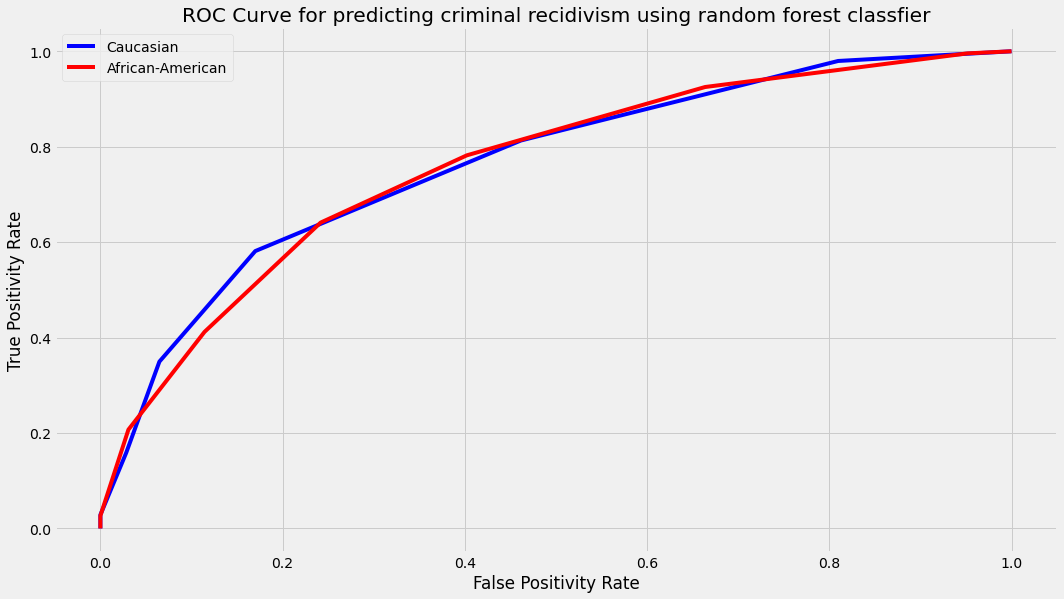

In [163]:
Caucasians_roc_curve_values = roc_curve(y_test = y_caucasian_test, y_prob = y_caucasian_prob, ths = ths)
African_American_roc_curve_values = roc_curve(y_test = y_african_test, y_prob = y_african_prob, ths = ths)

#plotting roc curves 
plt.figure(figsize=(16,9))
plt.plot(Caucasians_roc_curve_values[:,1], Caucasians_roc_curve_values[:,2], color= "blue",label= "Caucasian")
plt.plot(African_American_roc_curve_values[:,1], African_American_roc_curve_values[:,2], color="red", label= "African-American")
plt.xlabel("False Positivity Rate")
plt.ylabel("True Positivity Rate")
plt.title("ROC Curve for predicting criminal recidivism using random forest classfier");

plt.legend()
plt.grid(True)
plt.show()

From the plot above, we can see that for the third threshold value of the blue curve and the fourth threshold value forr the orange curve are really close to each other and give us an optimal true positivity rate of around 0.8 and false positivity rate of around 0.4.

In [25]:
closest_pts= closest_points(Caucasians_roc_curve_values,African_American_roc_curve_values)
print("Closest points between the caucasians and african american roc curves\n")
print("Caucasians \t\t\t\t African American")
print ("Threshold\tFPR\tTPR\tThreshold\tFPR\tTPR\tDistance")
for (pt1,pt2), distance in closest_pts:
    print(' {:0.2f}\t\t{:0.2f}\t {:0.2f}\t  {:0.2f}\t\t{:0.2f}\t{:0.2f}\t{:0.2f}'.format(pt1[0],pt1[1],pt1[2],pt2[0],pt2[1],pt2[2],distance))
    

Closest points between the caucasians and african american roc curves

Caucasians 				 African American
Threshold	FPR	TPR	Threshold	FPR	TPR	Distance
 0.00		1.00	 1.00	  0.00		1.00	1.00	0.00
 0.00		1.00	 1.00	  0.11		1.00	1.00	0.00
 0.11		1.00	 1.00	  0.00		1.00	1.00	0.00
 0.11		1.00	 1.00	  0.11		1.00	1.00	0.00
 0.89		0.00	 0.00	  1.00		0.00	0.00	0.00
 1.00		0.00	 0.00	  1.00		0.00	0.00	0.00
 0.78		0.00	 0.03	  0.89		0.00	0.03	0.00
 0.89		0.00	 0.00	  0.89		0.00	0.03	0.03
 1.00		0.00	 0.00	  0.89		0.00	0.03	0.03
 0.78		0.00	 0.03	  1.00		0.00	0.00	0.03
 0.00		1.00	 1.00	  0.22		0.95	1.00	0.05
 0.11		1.00	 1.00	  0.22		0.95	1.00	0.05
 0.67		0.03	 0.16	  0.78		0.03	0.21	0.05
 0.33		0.46	 0.81	  0.44		0.40	0.78	0.07
 0.56		0.06	 0.35	  0.67		0.11	0.41	0.08
 0.44		0.17	 0.58	  0.56		0.24	0.64	0.09
 0.67		0.03	 0.16	  0.89		0.00	0.03	0.14
 0.22		0.81	 0.98	  0.22		0.95	1.00	0.14
 0.56		0.06	 0.35	  0.78		0.03	0.21	0.15
 0.22		0.81	 0.98	  0.33		0.66	0.93	0.16
 0.67		0.03	 0.16	  1.00		0.00	

Also if you look at it mathematically, we can see the results above. We need a balanced TPR and FPR, otherwise it would be a bad classifier and also intersections close to the "ends" of the graphs are a bad choice. So what we need to do is to find a balance between a good classifier (balanced TPR and FPR) and minimize distance between points of the different thresholds (maximize fairness of the algorithm) by weighing up different options.

Threshold African-American: 0.4444 -> rather high TPR: 0.848

Threshold Caucasians: 0.3333 -> rather high TPR: 0.87

balance as distance is rather small, but TPRs are high -> alternatively high FPR possible, but larger distance -> the largest distance if really balanced TPRs

* **2.2.3: Debias the model output by re-computing with the thresholds you found**
    * Hint 1 This means that you have to take y_prob of your model African-Americans and apply Eq. (1) with the threshold for African-Americans, and then repeat with the different threshold for Caucasians.
    * Hint 2 You shouldn't rerun your model!
    

In [26]:
# Exercise 2.2.3
Caucasians_y_hat_calculate = y_hat_calculate(ths, y_caucasian_prob)
African_American_y_hat_calculate = y_hat_calculate(ths, y_african_prob)

th_African_American = ths[4]
th_Caucasians = ths[3]

y_hat_Afrian_American = African_American_y_hat_calculate[:,4]
y_hat_Caucasians = Caucasians_y_hat_calculate[:,3]

* **2.2.2.4:Now plot the confusion matrices for African-Americans and Caucasian after you debiased the method. What do you observe? What do you think the problem with this debiasing method is (Refer to Week 7 for more hints)?**

In [27]:
# https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56

print('Equal Odds Caucasians: ')
print(pd.crosstab(y_caucasian_test, y_hat_Caucasians, rownames=['Actual'], colnames=['Predicted']))

print('Equal OddsAfrican American: ')
print(pd.crosstab(y_african_test, y_hat_Afrian_American, rownames=['Actual'], colnames=['Predicted']))

Equal Odds Caucasians: 
Predicted  0.0  1.0
Actual             
0          133  114
1           46  200
Equal OddsAfrican American: 
Predicted  0.0  1.0
Actual             
0          272  183
1           99  355


## Part 3: Communicate your story and results to others


### Racist Machines of the Justice System. 

#### How do we stop racism creeping into legal machines ####

The criminal justice system’s problems with racism are not new. They start before the first contact and continue through pleas, conviction, incarceration, and release. But what is new, is the rise of these new racist machines which take all our historical racial baggage and learns from them as if this racial differences are indeed genetic and not a result of the bias that exist in the society.

Artificial intelligence, deep learning, and machine learning have transformed many industries and areas of sciences today.&nbsp;And, it is being applied in the criminal justice system of the US as well. One of the many applications of these advanced technologies is in the field of criminal recidivism(reoffending). 

Risk assessment is a popular application of machine learning and has become the new method for criminal risk analysis in the courtrooms of the 21st century. The results from these methods influence decisions from assigning bond amount to the defendants freedom and are also available to judges in certain places during criminal sentencing.

One such program, Correctional Offender Management Profiling for Alternative Sanctions (Compas), which has been found much more prone to mistakenly label black defendants as likely to reoffend – wrongly flagging them at almost twice the rate as white people (45% to 24%).

This makes one wonder that are these advanced technologies inherently racist? The answer is a resounding no. These technologies are not racist to begin with but since they learn from the data that we provide them, which is full of all our biases, the results are biased. The machine learns from the data we provide so if the data is flawed in the first place, then the resulting program would ingrain these prejudices within itself. 

Now you must wonder, how can data be biased; data is a collection of facts and and how can facts be biased?  

But they are actually a lot of issues when it comes to data biasing. So let us take you on a journey to show you what are these biases and how do they look like.

##### Distribution over age group #####

In [7]:
# Age group 
bins= [0,20,40,60,80,100]
labels = ['0-20','20-40','40-60','60-80','80-100']
df_preprocessed['age_group'] = pd.cut(df_preprocessed['age'], bins=bins, labels=labels, right=False)
df_age2= df_preprocessed.drop(columns=['age'])

In [8]:
df_age_groups = df_age2.groupby(by=['age_group']).sum()
df_age_groups['n_samples'] = df_age_groups['juv_fel_count'] + df_age_groups['juv_misd_count'] + df_age_groups['juv_other_count']
df_age_groups = df_age_groups.rename(columns={"two_year_recid":"n_rec_crimes"})
df_age_groups['frac_crimes'] = df_age_groups['n_rec_crimes']/df_age_groups['n_samples']
df_age_groups = pd.DataFrame(df_age_groups)
df_age_groups = df_age_groups.reset_index()
df_age_groups

age_group  juv_fel_count  juv_misd_count  juv_other_count  priors_count  \
0      0-20             14               8                8            33   
1     20-40            307             543              649         13394   
2     40-60             43               9               20          5870   
3     60-80              0               0                0           680   
4    80-100              0               0                0             2   

   n_rec_crimes  n_samples  frac_crimes  
0            26         30     0.866667  
1          2193       1499     1.462975  
2           536         72     7.444444  
3            47          0          inf  
4             1          0          inf

In [13]:
###AGE

#Convert your DataFrame to Bokeh ColumnDataSource

source = ColumnDataSource(df_age_groups)

#Create an empty figure
p = figure(title="N. of samples per age group", width=500, height=500, tools='hover', toolbar_location=None, 
           x_range=df_age_groups['age_group'].astype(str).tolist(), y_range='counts')

#Define the columns to use for each bar
bar_cols = ["n_samples", "frac_crimes"]
#Add bars by using p.var             
bar={}
#Create empty list for custom legend
items = []
for indx, i in enumerate(bar_cols):
    bar[i] = p.vbar(x='age_group', top=i, bottom=0, width=0.5, color=bar_cols[indx], source = source, legend_label=i)
    items.append((i,[bar[i]]))


p.add_tools(HoverTool(tooltips = [
    ("age_group", "@age_group"),
    ("n_sample", '@n_sample'),
    ('frac_crimes', '@frac_crimes')
    ]))


p.legend.orientation = "horizontal"
p.legend.location ="top_center"


show(p)

In [12]:
#SEX
df_sex = df_preprocessed.groupby(by=['sex']).sum()
df_sex['n_samples'] = df_sex['juv_fel_count'] + df_sex['juv_misd_count'] + df_sex['juv_other_count']
df_sex = df_sex.rename(columns={"two_year_recid":"n_rec_crimes"})
df_sex['frac_crimes'] = df_sex['n_rec_crimes']/df_sex['n_samples']
df_sex = pd.DataFrame(df_sex)
df_sex = df_sex.reset_index()


#Convert your DataFrame to Bokeh ColumnDataSource
source = ColumnDataSource(df_sex)

# plotting
p = figure(title="N. of samples per sex", width=500, height=500, tools='hover', toolbar_location=None, 
           x_range=df_sex['sex'], y_range=sorted(set(df_sex['n_samples'])))

#Define the columns to use for each bar
bar_cols = ["n_samples", "frac_crimes"]
    
#Define the columns to use for each bar    
bar={}
#Create empty list for custom legend
items = []
for indx, i in enumerate(bar_cols):
    bar[i] = p.vbar(x='sex', top=i, bottom=0, width=0.5, color=bar_cols[indx], source = source, legend_label=i)
    items.append((i,[bar[i]]))
     
p.add_tools(HoverTool(tooltips = [
    ("sex", "@sex"),
    ("n_sample", '@n_sample'),
    ('frac_crimes', '@frac_crimes')
    ]))


p.legend.orientation = "horizontal"
p.legend.location ="top_center"


show(p)

In [14]:
#RACE
df_race = df_preprocessed.groupby(by=['race']).sum()
df_race['n_samples'] = df_race['juv_fel_count'] + df_race['juv_misd_count'] + df_race['juv_other_count']
df_race = df_race.rename(columns={"two_year_recid":"n_rec_crimes"})
df_race['frac_crimes'] = df_race['n_rec_crimes']/df_race['n_samples']
df_race['frac_tot_crimes'] = df_race['n_samples']/(df_race['n_rec_crimes'].sum())
df_race = df_race.sort_values(by=['n_samples'])
df_race = pd.DataFrame(df_race)
df_race = df_race.reset_index()
#Convert your DataFrame to Bokeh ColumnDataSource

source = ColumnDataSource(df_race)

#Create an empty figure
p = figure(title="N. of samples per race", width=500, height=500, tools='hover', toolbar_location=None, 
           x_range=df_race['race'].astype(str).tolist(), y_range='counts')

#Define the columns to use for each bar
bar_cols = ["n_samples", "frac_crimes"]
   
#Add bars by using p.var             
bar={}
#Create empty list for custom legend
items = []
for indx, i in enumerate(bar_cols):
    bar[i] = p.vbar(x='race', top=i, bottom=0, width=0.5, color=bar_cols[indx], source = source, legend_label=i)
    items.append((i,[bar[i]]))

           
p.add_tools(HoverTool(tooltips = [
    ("race", "@race"),
    ("n_sample", '@n_sample'),
    ('frac_crimes', '@frac_crimes')
    ]))


p.legend.orientation = "horizontal"
p.legend.location ="top_center"
show(p)
output_notebook()

Loading BokehJS ...

#### Section 2: here we are visualizing Feature importances, Confusion Matrix and Percentage difference

Text(0, 0.5, 'Features')

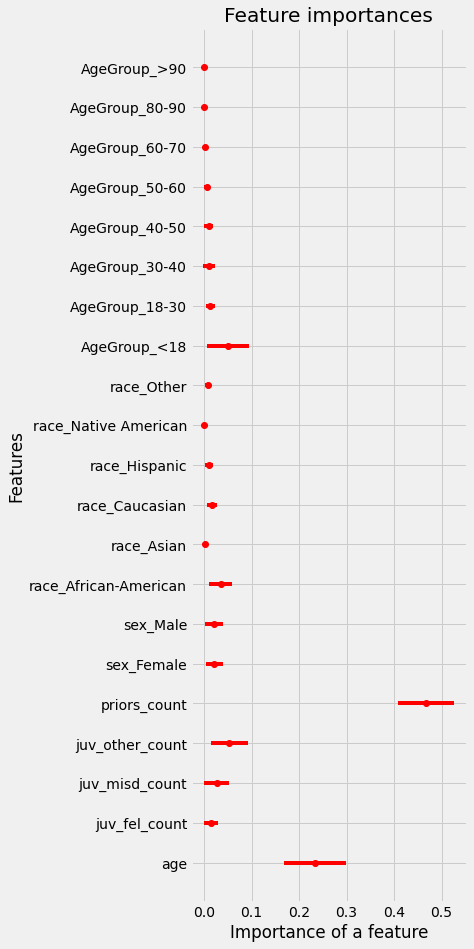

In [143]:
#Second viz here: (Week 8 Visualization 2) plot with 3 subplots (Feature importances, Confusion Matrix, Percentage difference)
 
X = df_dummies.loc[:, ~df_dummies.columns.isin(['two_year_recid'])]
y = df_dummies['two_year_recid']

# split the data set in train and test set (70/30 split) -> balanced data set grab equal amount of each target value
rus = RandomUnderSampler(random_state=42, sampling_strategy=1)
X_res, y_res = rus.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, stratify=y_res, random_state=42) 

#Feature importances
fig = plt.figure(figsize=(15,15))
fig.add_subplot(1, 3, 3)
importances = base_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in base_model.estimators_], axis=0)

y = X_train.columns # amount of features
x = importances

plt.title("Feature importances")
plt.errorbar(x, y, xerr=std, fmt = 'ro')
plt.xlabel("Importance of a feature")
plt.ylabel("Features")

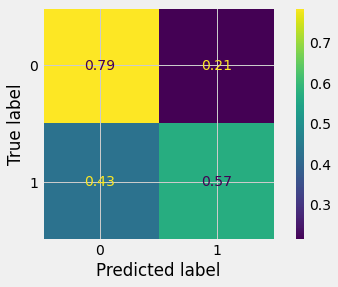

In [160]:
predictions_= base_model.predict(X_test)
cm_tot = confusion_matrix(y_test, predictions_, normalize="true", labels=base_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_tot, display_labels=base_model.classes_)
disp.plot()

<AxesSubplot:title={'center':'Percentage difference'}, ylabel='labels'>

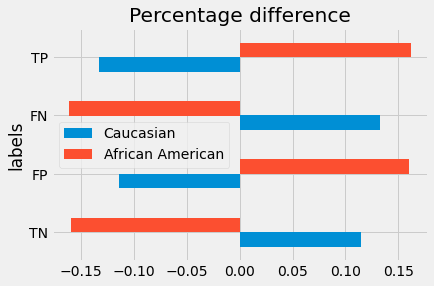

In [161]:
#Percentage difference

# using the obtianed  best model to get predictions for the data filtered for caucasian and african american 
y_pred_Caucasian = base_model.predict(X_caucasian_test)
y_pred_African_American = base_model.predict(X_african_test)
# Confusion Matrix
cm_ca = confusion_matrix(y_caucasian_test, y_pred_Caucasian, normalize="true", labels=base_model.classes_)
cm_aa = confusion_matrix(y_african_test, y_pred_African_American, normalize="true", labels=base_model.classes_)
d_aa = cm_aa - cm_tot
d_ca = cm_ca - cm_tot


df = pd.DataFrame({
    'labels': ["TN", "FP", "FN", "TP"],
    'Caucasian': [d_ca[0][0],d_ca[0][1],d_ca[1][0],d_ca[1][1]],
    'African American': [d_aa[0][0],d_aa[0][1],d_aa[1][0],d_aa[1][1]]
})
  
# plotting graph
df.plot(x="labels", y=["Caucasian", "African American"] ,  title='Percentage difference',kind="barh")



#### Section 3: here we are showing the ROC curve, selected threshold, TPR and FPR before and after debias 

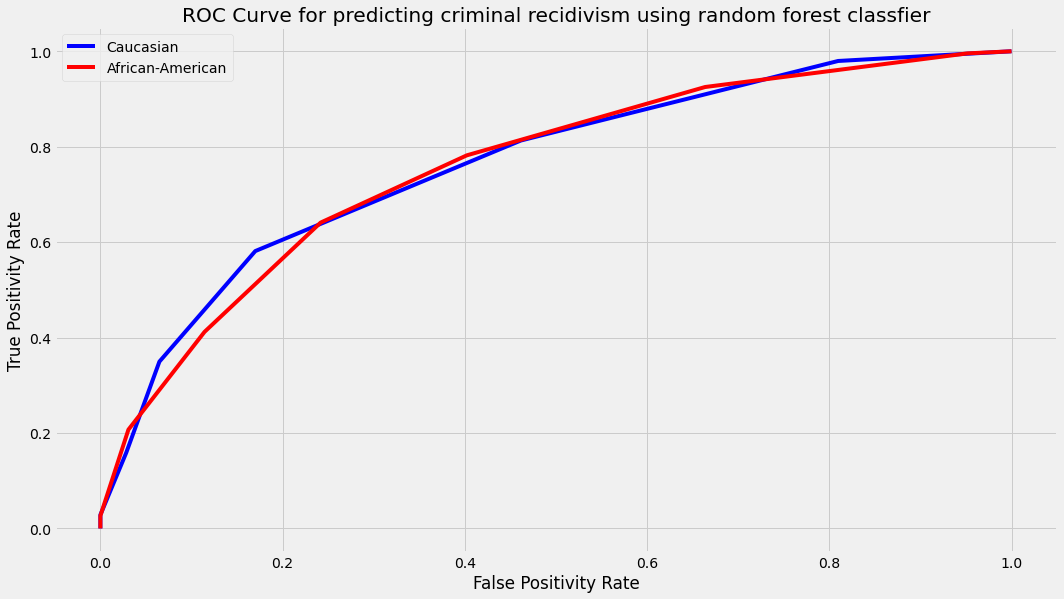

In [147]:
#Third viz here: (Week 8 Visualization 3) plot with 2 subplots (ROC curve and selected threshold, TPR and FPR before and after debiasing)
Caucasians_roc_curve_values = roc_curve(y_test = y_caucasian_test, y_prob = y_caucasian_prob, ths = ths)
African_American_roc_curve_values = roc_curve(y_test = y_african_test, y_prob = y_african_prob, ths = ths)

#plotting roc curves 
plt.figure(figsize=(16,9))
plt.plot(Caucasians_roc_curve_values[:,1], Caucasians_roc_curve_values[:,2], color= "blue",label= "Caucasian")
plt.plot(African_American_roc_curve_values[:,1], African_American_roc_curve_values[:,2], color="red", label= "African-American")
plt.xlabel("False Positivity Rate")
plt.ylabel("True Positivity Rate")
plt.title("ROC Curve for predicting criminal recidivism using random forest classfier");

plt.legend()
plt.grid(True)
plt.show()

***Results from debiasing method*** 

The third visualization shows the different true criminal detection rate and false criminal detection rates depending on the different threshold limits chosen for the risk values outputed by the algorithm. So for example if the algorithm assigns 0.5 to a defendant, so if we choose threshold as 0.6 then the defendant is classified as not likely to recommit crime  but if we choose threshold as 0.4 then the defendant is classfied as likely to recommit crime.  

So its the threshold value that eventually makes this final choice. So in order to introduce fairness among different groups, we can choose different threshold values for different groups which would give us a fairly equal hit/miss rate regardless go the social group you belong to and inherent biases in the data.

So in the graph above if we use threshold 3 for African-American and threshold 4 for caucasian then we get almost similar true positivity rates. Lets see the results in a confusion matrix

In [171]:
print('Equal Odds Caucasians: ')
print(pd.crosstab(y_caucasian_test, y_hat_Caucasians, rownames=['Actual'], colnames=['Predicted']))

print('Equal OddsAfrican American: ')
print(pd.crosstab(y_african_test, y_hat_Afrian_American, rownames=['Actual'], colnames=['Predicted']))

Equal Odds Caucasians: 
Predicted  0.0  1.0
Actual             
0          133  114
1           46  200
Equal OddsAfrican American: 
Predicted  0.0  1.0
Actual             
0          272  183
1           99  355


***Limitations and conclusions**

The results from the exploratory data analysis and the classification task, show how the biases of society are learned through biased data by machine learning algorithms. This raises the age old issue of fairness in society when it comes to outcomes regardless of your age, gender or race. The debasing results show a ray of light in these more and more opaque world of machine learning  where “unfair” classifiers  can be reasonably cleaned from biases learned from historical data.

Though these unbiasing methods, cannot  eliminate bias from these decisions entirely, but they give us hope that the data scientists are aware of the flaws of the algorithms they are building and are actively trying to come with new methods to eliminate biases from machines.

***References***

* https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/
* https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html.

***Assignment Contributions:*** 
* ST33 - part 1(30%) part 2(30%) part3(40%)
* ST161 - part 1(30%) part 2(40%) part 3(30%)
* ST191 - part 1(40%) part 2(30%) part 3(30%)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1e938a1f-7331-424c-83bd-6f07581e768c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>